In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df= pd.read_csv("Amazon Sale Report.csv", dtype={"Unnamed: 22": str})

In [ ]:
# 1. Data Preprocessing

In [3]:
df=df.drop(["index","Unnamed: 22","currency", "ship-country"], axis=1)

In [4]:
df=df.dropna()
df = df.drop_duplicates()

In [5]:
df["SKU"].value_counts()

SKU
JNE3797-KR-L       455
JNE3797-KR-M       414
JNE3797-KR-S       306
SET183-KR-DH-M     288
JNE3797-KR-XL      282
                  ... 
MEN5016-KR-XXXL      1
BTM044-PP-XL         1
JNE3751-KR-M         1
SET375-KR-NP-M       1
J0079-SKD-S          1
Name: count, Length: 4600, dtype: int64

In [6]:
df['Qty']=df['Qty'].astype(int)

In [7]:
df['Qty'].dtype

dtype('int32')

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%m-%d-%y')

In [10]:
df['unit_price'] = df['Amount'] / df['Qty']
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()
df['Year'] = df['Date'].dt.year

In [ ]:
df=df[df['Amount']>0]

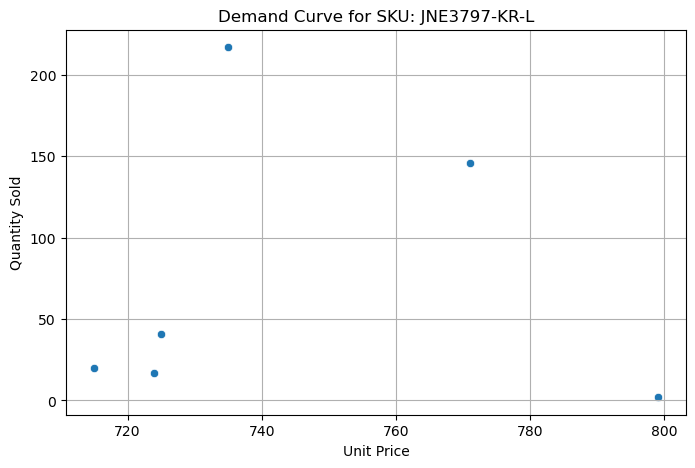

In [22]:
# 2. Demand Curve Estimation
sku_group = df[df['SKU'] == 'JNE3797-KR-L']
price_qty = sku_group.groupby('unit_price')['Qty'].sum().reset_index()
# Plot demand curve
plt.figure(figsize=(8,5))
sns.scatterplot(data=price_qty, x='unit_price', y='Qty')
plt.title('Demand Curve for SKU: JNE3797-KR-L')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Fit log-linear demand model
price_qty['log_qty'] = np.log(price_qty['Qty'])
X = price_qty[['unit_price']]
y = price_qty['log_qty']
model = LinearRegression()
model.fit(X, y)

elasticity = -model.coef_[0]
print(f"Estimated Price Elasticity: {elasticity:.3f}")

Estimated Price Elasticity: 0.020


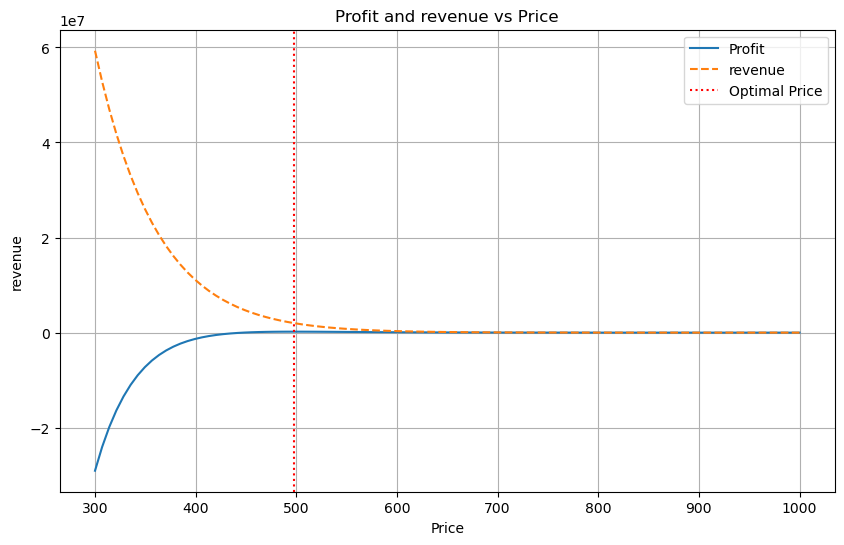

Optimal price for maximum profit: Rs 497.98


In [19]:
# 3. Dynamic Pricing Simulation
# Assuming constant cost (e.g., 60% of avg price)
avg_price = sku_group['unit_price'].mean()
cost = 0.6 * avg_price

# Define demand prediction and profit simulation
def predict_demand(price):
    log_qty = model.intercept_ + model.coef_[0] * price
    return np.exp(log_qty)

def compute_profit(price):
    qty = predict_demand(price)
    revenue = price * qty
    profit = (price - cost) * qty
    return revenue, profit

# Simulate for a range of prices
prices = np.linspace(300, 1000, 100)
simulation = pd.DataFrame({'Price': prices})
simulation['Predicted_Demand'] = simulation['Price'].apply(predict_demand)
simulation['revenue'], simulation['Profit'] = zip(*simulation['Price'].apply(compute_profit))

# Plot profit curve
plt.figure(figsize=(10,6))
plt.plot(simulation['Price'], simulation['Profit'], label='Profit')
plt.plot(simulation['Price'], simulation['revenue'], label='revenue', linestyle='--')
plt.axvline(simulation.loc[simulation['Profit'].idxmax(), 'Price'], color='r', linestyle=':', label='Optimal Price')
plt.title('Profit and revenue vs Price')
plt.xlabel('Price')
plt.ylabel('revenue')
plt.legend()
plt.grid(True)
plt.show()

optimal_price = simulation.loc[simulation['Profit'].idxmax(), 'Price']
print(f"Optimal price for maximum profit: Rs {optimal_price:.2f}")


In [20]:
# 4. Segmentation Analysis

# Example: Compare elasticity across categories
category_elasticities = {}
for cat in df['Category'].unique():
    group = df[df['Category'] == cat]
    grouped = group.groupby('unit_price')['Qty'].sum().reset_index()
    if len(grouped) > 5:
        grouped['log_qty'] = np.log(grouped['Qty'])
        X = grouped[['unit_price']]
        y = grouped['log_qty']
        reg = LinearRegression()
        reg.fit(X, y)
        category_elasticities[cat] = -reg.coef_[0]

print("\nPrice Elasticities by Category:")
for cat, el in category_elasticities.items():
    print(f"{cat}: {el:.2f}")


Price Elasticities by Category:
kurta: 0.00
Set: 0.00
Bottom: 0.00
Western Dress: -0.00
Top: 0.00
Blouse: -0.00
Ethnic Dress: -0.00
Saree: -0.00


In [21]:
# 5. Evaluation & Scenario Testing

# Baseline Revenue (actual)
baseline_revenue = df['Amount'].sum()

# Simulated Revenue at Optimal Price for SKU
optimal_demand = predict_demand(optimal_price)
simulated_revenue = optimal_price * optimal_demand

print(f"\nBaseline Revenue (All SKUs): Rs {baseline_revenue:,.2f}")
print(f"Simulated Revenue for SKU at Optimal Price: Rs {simulated_revenue:,.2f}")

# Scenario: 10% promotion
promo_price = 0.9 * avg_price
promo_demand = predict_demand(promo_price)
promo_revenue = promo_price * promo_demand
print(f"\nPromotion Scenario (10% off):")
print(f"Price: Rs {promo_price:.2f}, Expected Revenue: Rs {promo_revenue:.2f}")


Baseline Revenue (All SKUs): Rs 21,061,286.00
Simulated Revenue for SKU at Optimal Price: Rs 1,994,062.28

Promotion Scenario (10% off):
Price: Rs 670.41, Expected Revenue: Rs 89935.58
